In [34]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from kmeans_plus import KmeansPlus

In [2]:
data = pd.read_csv('../data/merged_data.csv')
subway = pd.read_csv('../data/subwayInfo.csv')
subway = subway.drop_duplicates()

# 지하철 그룹별 데이터 생성
- 가장 가까운 지하철을 기준으로 지역 그룹화
- 각 지역별 변수 생성
  - 1km내 지하철역, 공원, 학교 수
  - 단위면적당 전세가 평균 로그 변환 (치우친 분포 완화용)
  - 기준 지하철 위도, 경도

In [27]:
# KD-Tree를 사용해 가장 가까운 공간을 찾는 함수
def find_nearest_place(lat, lon, place_tree, place_coordinates):
    # 주어진 좌표에 대해 가장 가까운 공간 인덱스 찾기
    distance, index = place_tree.query([lat, lon], k=1)
    
    # 가장 가까운 지하철 역의 좌표
    nearest_place = place_coordinates[index]
    
    return index, nearest_place[0], nearest_place[1]


# KD-Tree를 사용해 반경 안의 공간 개수를 찾는 함수
def count_within_radius(radius, lat, lon, place_tree):
    # 주어진 좌표에 대해 가장 가까운 공간 인덱스 찾기
    counts = place_tree.query_ball_point([lat, lon], r=radius, return_length = True)    
    return counts

In [28]:
# 각 아파트별 가장 가까운 지하철, 경도, 위도 변수 생성
apartment_loc = data[['latitude', 'longitude']].drop_duplicates()
subway_coordinates = subway[['latitude', 'longitude']].values
subway_tree = cKDTree(subway_coordinates)

apartment_loc['closest_subway'], apartment_loc['latitude_subway'], apartment_loc['longitude_subway'] = zip(*apartment_loc.apply(
    lambda row: find_nearest_place(row['latitude'], row['longitude'], subway_tree, subway_coordinates), axis=1))

In [29]:
# 1km 내 지하철 개수 변수 생성
km = 1
radius = km/111
apartment_loc['subway_count_1km'] = apartment_loc.apply(lambda row: count_within_radius(radius, row['latitude'], row['longitude'], subway_tree), axis=1)

In [30]:
data = data.merge(apartment_loc, how = 'left')

In [31]:
# 단위면적당 전세가 로그 변환
data['deposit_per_area_log'] = np.log(data['deposit'] /data['area_m2'])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
train_data = data[data._type == 'train']

In [33]:
# 지하철 그룹별 단위면적당 전세가 로그 평균
deposit_mean = train_data.groupby(['closest_subway','latitude_subway', 'longitude_subway'])['deposit_per_area_log'].mean().reset_index()

# 주변 환경 변수 (학교, 공원, 지하철)
background = data[['closest_subway','latitude_subway', 'longitude_subway', 'latitude', 'longitude', 'park_count_1000m', 'school_count_within_1km', 'subway_count_1km']].drop_duplicates()
background = background.groupby(['closest_subway','latitude_subway', 'longitude_subway'])[['park_count_1000m', 'school_count_within_1km', 'subway_count_1km']].mean().reset_index()

# 최종 클러스터용 데이터
cluster_data = deposit_mean.merge(background)
cluster_data

,closest_subway,latitude_subway,longitude_subway,deposit_per_area_log,park_count_1000m,school_count_within_1km,subway_count_1km
0,0,37.759380,127.042292,5.693062,9.333333,6.250000,0.750000
1,1,37.541021,126.971300,6.717719,12.266667,8.933333,4.133333
2,2,37.529849,126.964561,6.353845,6.750000,2.950000,0.750000
3,3,37.514219,126.942454,6.598562,6.375000,5.375000,2.000000
4,4,37.513342,126.926382,6.464711,3.961538,11.615385,2.807692
...,...,...,...,...,...,...,...
548,578,37.382268,126.656365,6.091230,7.200000,3.800000,0.800000
549,579,37.378384,126.645168,6.117513,9.833333,4.500000,1.166667
550,580,37.386007,126.639484,6.121107,9.400000,5.150000,0.600000
551,581,37.393054,126.634729,6.151377,6.318182,5.181818,0.818182


In [15]:
# 스케일링
scaler = StandardScaler()

feature = cluster_data.drop('closest_subway', axis=1)
feature = scaler.fit_transform(feature)

# Kmeans++ 클러스터링

In [35]:
X = np.array(feature)

kmp = KmeansPlus(X, k=3)
labels, centroids = kmp.k_means()

### 지하철 그룹별 시각화

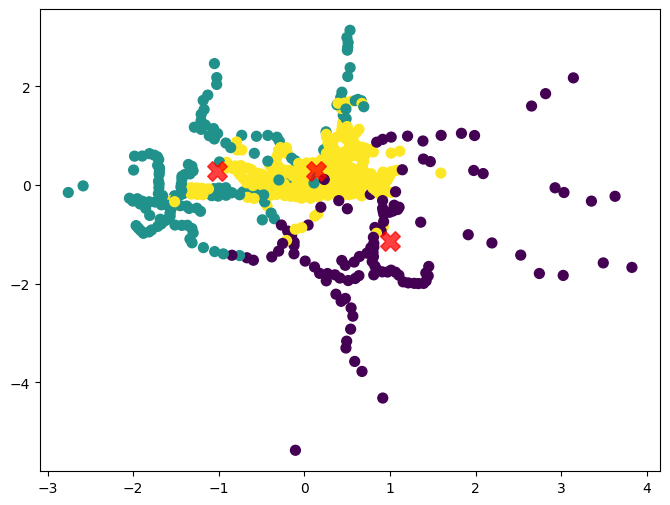

In [36]:
# 시각화
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot for data points
scat = ax.scatter(X[:, 1], X[:, 0], c=labels, s=50, cmap='viridis')
cent_scat = ax.scatter(centroids[:, 1], centroids[:, 0], c='red', s=200, alpha=0.75, marker='X')

In [37]:
cluster_data['cluster'] = labels
cluster_data.cluster.value_counts()

cluster
2    295
1    148
0    110
Name: count, dtype: int64

### 아파트별 시각화

In [38]:
data = data.merge(cluster_data[['closest_subway', 'cluster']], how = 'left')

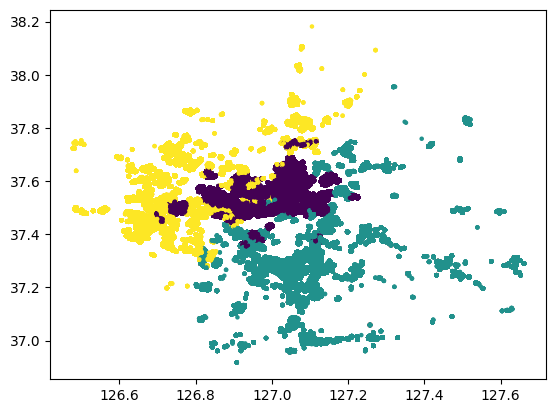

In [25]:
plt.scatter(data.longitude, data.latitude, c=data.cluster, s=5, cmap='viridis')

In [26]:
data.cluster.value_counts()

cluster
0    789613
1    590966
2    487203
Name: count, dtype: int64